In [ ]:
import warnings
warnings.simplefilter('ignore')

import numpy as np # 線性代數
import pandas as pd # 數據處理，CSV文件I/O（如pd.read_csv）

import os #遍歷目錄

import plotly.graph_objects as go # 生成圖形
from plotly.subplots import make_subplots #創建子圖

from sklearn import decomposition #pca
from sklearn.preprocessing import StandardScaler # 標準化 ((X - X_mean)/X_std)

from sklearn.neighbors import KNeighborsClassifier #KNN 模型
from sklearn.ensemble import RandomForestClassifier #RandomForest 模型
from sklearn.linear_model import LogisticRegression  #Logistic 模型

from sklearn.model_selection import train_test_split # 拆分成train和test

from sklearn.model_selection import GridSearchCV #超參數調整
from sklearn.model_selection import cross_val_score#cross validation score

# **資料前處理**

### **導入數據及觀察**

In [ ]:
#匯入資料並觀測欄位
missing_values = ['?', '--', ' ', 'NA', 'N/A', '-'] #有時缺失值不是 NaN 的形式
df = pd.read_csv('cardio_train.csv', delimiter = ';', na_values = missing_values)
#給na_values參數傳值，補充一些自定義的等同於缺失的值
print('There are Total {} datapoints in the dataset with {} Features listed as {}:'.format(df.shape[0], df.shape[1], df.columns.values))

There are Total 70000 datapoints in the dataset with 13 Features listed as ['id' 'age' 'gender' 'height' 'weight' 'ap_hi' 'ap_lo' 'cholesterol'
 'gluc' 'smoke' 'alco' 'active' 'cardio']:


In [ ]:
#資料欄位及型別
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [ ]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
#刪除不可參考欄位(id)
df.drop(columns=['id'], inplace=True)

### **連續變數**

In [ ]:
#連續變數
df[['age','height','weight','ap_hi','ap_lo']].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414
std,2467.251667,8.210126,14.395757,154.011419,188.472530
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


### **類別變數**

In [ ]:
#心血管疾病有無比例
fig = go.Figure([go.Pie(labels=['Not Having CVD', 'Having CVD'],values=df['cardio'].value_counts().values)])
fig.update_layout(title_text="Pie chart of Target Variable", template="plotly_white")
fig.data[0].marker.line.color = 'rgb(255, 255, 255)'
fig.data[0].marker.line.width = 2
fig.update_traces(hole=.4,)
fig.show()

In [ ]:
#個個分類項目的佔比
fig = make_subplots(rows=2, cols=3,subplot_titles=("Alchoal Distribution", "Gender Distribution", "Choslesterol Distribution", "Glucose Distribution", "Smoking Distribution", "Fitness Distribution"), specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels=['Non Alchoalic', 'Alchoalic'],values=df['alco'].value_counts().values, name = 'Alchoal Status'), 1, 1)
fig.add_trace(go.Pie(labels=['Female', 'Male'],values=df['gender'].value_counts().values, name = 'Gender Status'), 1, 2)

fig.add_trace(go.Pie(labels=['Normal', 'Above Normal', 'Well Above Normal'],values=df['cholesterol'].value_counts().values, name = 'Cholesterol Level Status'), 1, 3)
fig.add_trace(go.Pie(labels=['Normal', 'Above Normal', 'Well Above Normal'],values=df['gluc'].value_counts().values, name = 'Glucose Level Status'), 2, 1)

fig.add_trace(go.Pie(labels=['Non Smoker', 'Smoker'],values=df['smoke'].value_counts().values, name = 'Smoking Status'), 2, 2)
fig.add_trace(go.Pie(labels=['Not Involved in Physical Activites', 'Involved in Physical Activites'],values=df['active'].value_counts().values, name = 'Fitness Status'), 2, 3)

fig.update_traces(hole=.4,)
fig.update_layout(title_text="Distribution of Various Categorial Values")

fig.show()

### **缺失/重複值**

In [ ]:
#檢查是否有空值
features_with_null = [features for feature in df.columns if df[feature].isnull().sum()>0]
if features_with_null:
    print('Features with Null Values {}'.format(features_with_null))
else:
    print('Dataset contains no Null Values')

Dataset contains no Null Values


In [ ]:
#檢查是重複資料出現(發現24筆)
duplicate_sum = df.duplicated().sum()#發現重複值可以用duplicated()，括號什麼都不填，每一列的值都必須一致才會被標記為重複值
if duplicate_sum:
  print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
  print('Dataset contains no Duplicate Values')
print('\n',df[df.duplicated()])

Duplicates Rows in Dataset are : 24

          age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
10562  20495       1     165    70.0    120     80            1     1      0   
21784  16793       1     165    68.0    120     80            1     1      0   
38505  18988       1     164    65.0    120     80            1     1      0   
40365  14552       1     158    64.0    120     80            1     1      0   
42450  18353       1     169    67.0    120     80            1     1      0   
44653  16937       2     170    70.0    120     80            1     1      0   
45125  21280       1     165    65.0    120     80            1     1      0   
45748  22077       1     175    69.0    120     80            1     1      0   
45810  21230       1     164    62.0    120     80            1     1      0   
48917  21945       1     165    60.0    120     80            1     1      0   
50432  17493       2     169    74.0    120     80            1     1      0   
52

In [ ]:
#找尋重複值(觀測重複資料)
duplicated = df[df.duplicated(keep=False)]#keep-保留第一筆(first)、最後一筆(last)或全部(False)的重複資料/subset-查找特定欄位的重複資料
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [ ]:
#清理重複值
df.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(df.shape[0], df.shape[1]))

Total 69976 datapoints remaining with 12 features


In [ ]:
duplicate_sum = df.duplicated().sum()
print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))

Duplicates Rows in Dataset are : 0


### **連續值**

In [ ]:
Continuous_features = [feature for feature in df.columns if len(df[feature].unique())>25]
print('Continuous Values are : {}'.format(Continuous_features))

Continuous Values are : ['age', 'height', 'weight', 'ap_hi', 'ap_lo']


In [ ]:
df[Continuous_features].head()

,age,height,weight,ap_hi,ap_lo
0,18393,168,62.0,110,80
1,20228,156,85.0,140,90
2,18857,165,64.0,130,70
3,17623,169,82.0,150,100
4,17474,156,56.0,100,60


### **異常值**

In [ ]:
#數值分佈
df[Continuous_features].describe()

,age,height,weight,ap_hi,ap_lo
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


In [ ]:
#盒型圖觀測(身高&體重)
fig = go.Figure()

fig.add_trace(go.Box(x=df['height'], name = 'Height', boxpoints='outliers',))
fig.add_trace(go.Box(x=df['weight'], name = 'Weight', boxpoints='outliers',))

fig.update_layout(title_text="Box Plot for Weight and Height with Outliers")
fig.show()

In [ ]:
#分別算出身高及體重的異常值數目(outliers方法計算出設置條件下的異常值數目)
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 給定特徵數據的第25個百分位數(Q1)
        Q3 = np.percentile(feature_data, 75.) # 給定特徵的數據的第75個百分位數(Q3)
        IQR = Q3-Q1 #四分位距
        outlier_step = IQR * 1.5 
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()# 異常值  
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))
outliers(df[['height', 'weight']])

For the feature height, No of Outliers is 519
For the feature weight, No of Outliers is 1819


In [ ]:
#轉換變量(可以消除異常值，並且大限度地減少需要丟失的數據)
outline_free_df = df.copy()
outline_free_df[['height', 'weight']] = np.log(outline_free_df[['height', 'weight']])
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 484
For the feature weight, No of Outliers is 1174


In [ ]:
#最後定義0.005和0.995分位數範圍處理剩餘的異常值
outline_free_df = outline_free_df[(outline_free_df['weight'] > outline_free_df['weight'].quantile(0.005)) & (outline_free_df['weight'] < outline_free_df['weight'].quantile(0.995))]
outline_free_df = outline_free_df[(outline_free_df['height'] > outline_free_df['height'].quantile(0.005)) & (outline_free_df['height'] < outline_free_df['height'].quantile(0.995))]
outliers(outline_free_df[['height', 'weight']])

For the feature height, No of Outliers is 0
For the feature weight, No of Outliers is 349


In [ ]:
#處理掉的異常值數目(身高和體重加總)
print('Handling outliners cost us {} datapoints'.format(len(df)-len(outline_free_df)))

Handling outliners cost us 1630 datapoints


In [ ]:
outline_free_df.shape #排除身高體重異常值剩餘的資料筆數outline_free_df

(68346, 12)

In [ ]:
#處理收縮、舒張壓的異常值
#先排除負的資料
outline_free_df = outline_free_df[outline_free_df['ap_lo']>=0]
outline_free_df = outline_free_df[outline_free_df['ap_hi']>=0]

In [ ]:
#收縮壓中減去舒張壓得到的脈壓不能為負(ap_hi > ap_lo)
print('There are total {} observations where ap_hi < ap_lo'.
      format(len(outline_free_df[outline_free_df['ap_hi'] < outline_free_df['ap_lo']])))

There are total 1182 observations where ap_hi < ap_lo


In [ ]:
#取出收縮壓較大的資料為新的資料集 
cleaned_data = outline_free_df[outline_free_df['ap_hi'] >= outline_free_df['ap_lo']].reset_index(drop=True)
print('Total observations preserved : {}'.format(len(cleaned_data)))

Total observations preserved : 67156


In [ ]:
cleaned_data.shape #整理完的資料cleaned_data(排除基本錯收縮舒張壓資料)

(67156, 12)

In [ ]:
#血壓正常值為120/80mmHg
#排除不在正常區間的收縮舒張壓(收縮>250，舒張>200的異常數目)
#人的血壓達到最高且未死亡的記錄是收縮壓250毫米汞柱(https://kknews.cc/health/g336a89.html)
#收縮壓與舒張壓相差超過60mmHg就叫壓差大(https://heho.com.tw/archives/50623)
print('As per our assumptions we have total {} outliers'.format(len(cleaned_data[(cleaned_data["ap_hi"]>250) | (cleaned_data["ap_lo"]>200)])))
cleaned_data = cleaned_data[(cleaned_data["ap_hi"]<=250) & (cleaned_data["ap_lo"]<=200)]

As per our assumptions we have total 38 outliers


In [ ]:
#取正常範圍收縮舒張壓
cleaned_data.shape #清理完所有異常值資料集(cleaned_data)

(67118, 12)

### **年齡換算(天變年)**

In [ ]:
#處理年齡(天換算年)
import matplotlib.pyplot as plt
import seaborn as sns
cleaned_data['age'] = cleaned_data['age'].div(365).apply(lambda x: int(x))
fig = go.Figure()
fig.add_trace(go.Histogram(x=cleaned_data['age'], name = 'Age'))
fig.show()
#數據集中的大多數人屬於 49 至 60 歲年齡段
#沒有對年齡進行四捨五入，我們數據集中的最大年齡是 64 歲

In [ ]:
#換算年發現出現多筆重複值
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [ ]:
#觀測重複項
duplicated = cleaned_data[cleaned_data.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()
#選擇以天為單位保持年齡或是刪除重複行（保持年齡）

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22272,57,2,5.192957,4.605170,120,80,1,1,0,0,1,0
58984,57,2,5.192957,4.605170,120,80,1,1,0,0,1,0
9953,40,2,5.192957,4.382027,120,80,1,1,0,0,1,0
20350,56,2,5.192957,4.382027,150,90,1,1,0,0,1,1
28371,56,2,5.192957,4.382027,150,90,1,1,0,0,1,1


In [ ]:
#確認沒有重複項
duplicate_sum = cleaned_data.duplicated().sum()
if duplicate_sum:
    print('Duplicates Rows in Dataset are : {}'.format(duplicate_sum))
else:
    print('Dataset contains no Duplicate Values')

Duplicates Rows in Dataset are : 3180


In [ ]:
#刪除重複行
cleaned_data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(cleaned_data.shape[0], df.shape[1]))

Total 63938 datapoints remaining with 12 features


# **觀測各項因素對於心血管的影響**

### **連續變數觀測**

In [ ]:
#年齡及心血管的分布
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['age'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['age'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Age groups grouped by Target Value", 
                  yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Age',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()
#低年齡組的人患心血管疾病的機率較低
#在達到峰值後，在這種情況下是 53 歲的年齡組圖顯示非 CVD 和增加的 CVD 病例的不良形狀
#年齡越大的人患 CVD 的機會就越大

In [ ]:
#身高體重和心血管分布
fig = make_subplots(rows=2, cols=2, subplot_titles=("Height Distribution for CVD Population", "Height Distribution for non CVD Population", "Weight Distribution for CVD Population", "Weight Distribution for non CVD Population"))

trace0 = go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 0]['height']), name = 'Non CVD')
trace1 = go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 1]['height']), name = 'CVD')

trace2 = go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 0]['weight']), name = 'Non CVD')
trace3 = go.Histogram(x=np.exp(cleaned_data[cleaned_data['cardio'] == 1]['weight']), name = 'CVD')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig.update_xaxes(title_text="Height", row=1, col=1)
fig.update_yaxes(title_text="Total Count", row=1, col=1)

fig.update_xaxes(title_text="Height", row=1, col=2)
fig.update_yaxes(title_text="Total Count", row=1, col=2)

fig.update_xaxes(title_text="Weight", row=2, col=1)
fig.update_yaxes(title_text="Total Count", row=2, col=1)

fig.update_xaxes(title_text="Weight", row=2, col=2)
fig.update_yaxes(title_text="Total Count", row=2, col=2)

fig.show()
#體重和身高等特徵在非 CVD 和 CVD 人群中分佈良好(沒太大關係)

In [ ]:
#收縮壓vs心血管(收縮壓正常值為120mmHg)
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['ap_hi'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['ap_hi'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Systolic blood pressure Values grouped by Target Value(收縮壓)", 
                  yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Systolic Blood Pressure Values',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

In [ ]:
#舒張壓vs心血管(舒張壓正常值為80mmHg)
fig = go.Figure(data=[go.Bar(x = cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 0]['ap_lo'].value_counts().values, name = 'Non CVD'),
                      go.Bar(x = cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().index.to_list(), 
                             y =cleaned_data[cleaned_data['cardio'] == 1]['ap_lo'].value_counts().values, name = 'CVD')]
               )

fig.update_layout(barmode='group', xaxis_tickangle=-45, title_text="Distribution of Systolic blood pressure Values grouped by Target Value(舒張壓)", 
                  yaxis=dict(
        title='Total Count',
        titlefont_size=16,
        tickfont_size=14,
    ),     xaxis=dict(
        title='Systolic Blood Pressure Values',
        titlefont_size=16,
        tickfont_size=14,
    ))
fig.show()

### **類別變數觀測**

In [ ]:
Categorial_features = [feature for feature in cleaned_data.columns if len(cleaned_data[feature].unique())<25]
print('Categorial Values are : {}'.format(Categorial_features))

Categorial Values are : ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


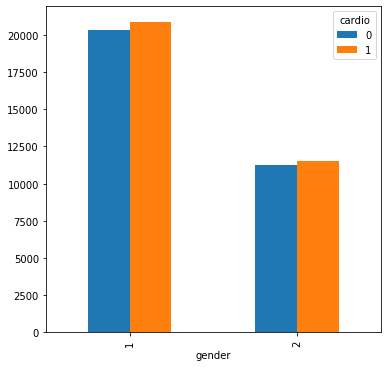

In [ ]:
#性別
pd.crosstab(cleaned_data.gender,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

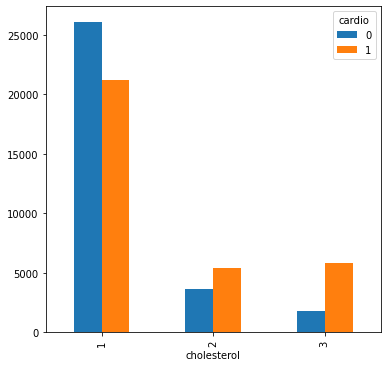

In [ ]:
#膽固醇
pd.crosstab(cleaned_data.cholesterol,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

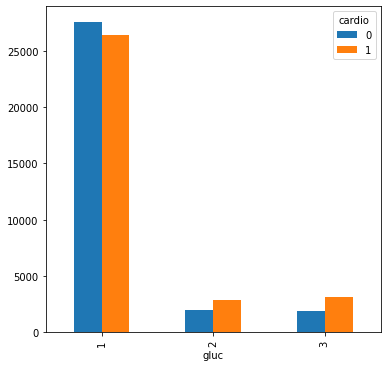

In [ ]:
#葡萄糖
pd.crosstab(cleaned_data.gluc,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

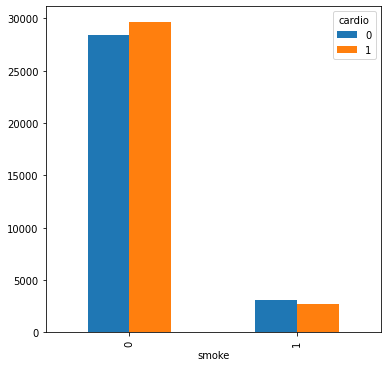

In [ ]:
#吸菸
pd.crosstab(cleaned_data.smoke,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

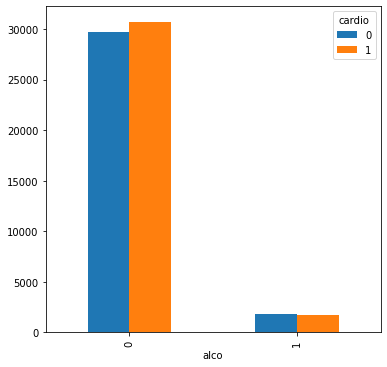

In [ ]:
#喝酒
pd.crosstab(cleaned_data.alco,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

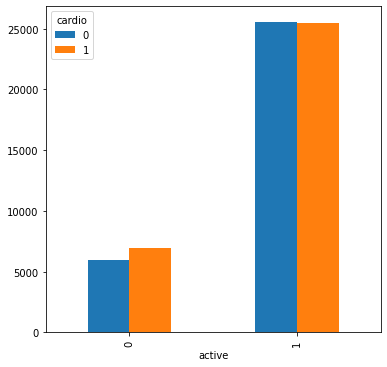

In [ ]:
#活動
pd.crosstab(cleaned_data.active,cleaned_data.cardio).plot(kind='bar',figsize=(6,6))

### **增加欄位**

In [ ]:
def BMI(data):
    return np.exp(data['weight']) / (np.exp(data['height'])/100)**2 
 
cleaned_data['bmi'] = cleaned_data.apply(BMI, axis=1)

In [ ]:
cleaned_data.insert(7, 'pulse', round(np.subtract(cleaned_data['ap_hi'], cleaned_data['ap_lo'])), 2)

### **相關矩陣**

In [77]:
#取出連續變數做相關矩陣
Numdata = cleaned_data[['age','height','weight','bmi','gluc','ap_hi','ap_lo','pulse']]

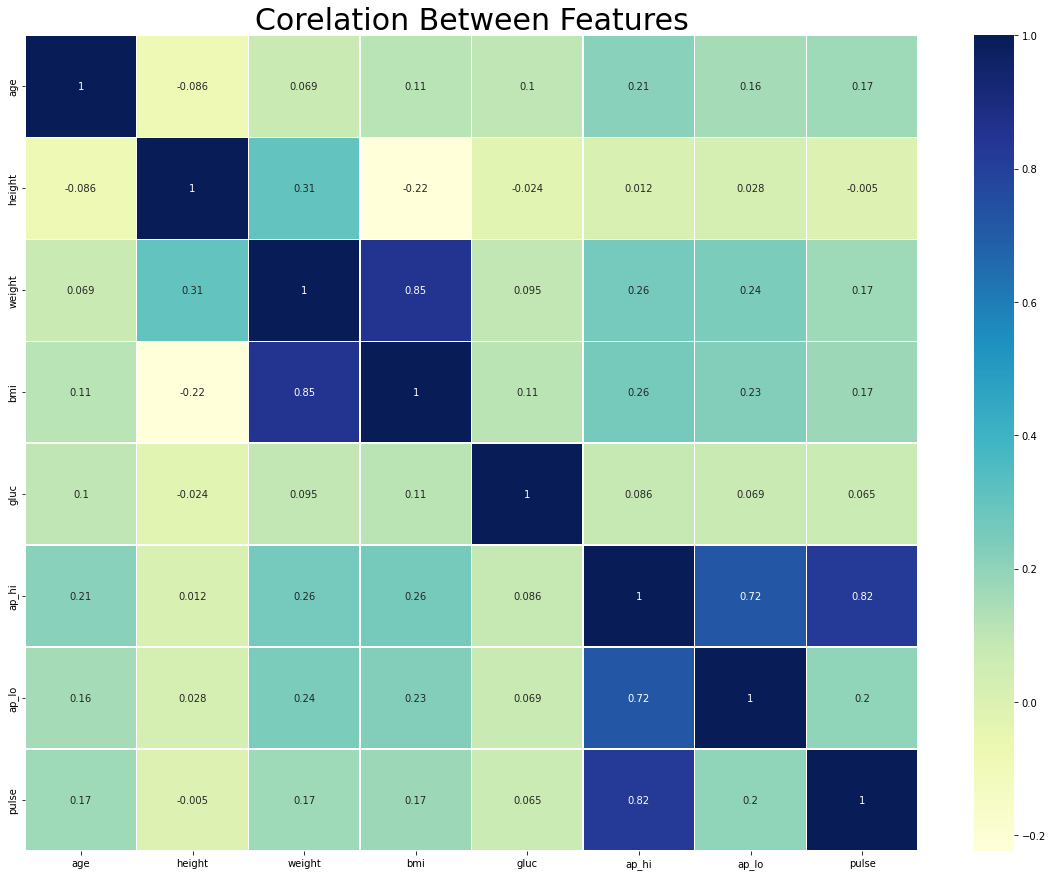

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(Numdata.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

In [79]:
#計算相關矩陣
Numdata.corr()

,age,height,weight,bmi,gluc,ap_hi,ap_lo,pulse
age,1.000000,-0.085891,0.069198,0.111950,0.099802,0.211517,0.155293,0.171808
height,-0.085891,1.000000,0.306232,-0.223667,-0.023936,0.012383,0.027513,-0.004967
weight,0.069198,0.306232,1.000000,0.852465,0.094698,0.260181,0.243737,0.168340
bmi,0.111950,-0.223667,0.852465,1.000000,0.110360,0.256431,0.230363,0.173956
gluc,0.099802,-0.023936,0.094698,0.110360,1.000000,0.085691,0.069090,0.064566
ap_hi,0.211517,0.012383,0.260181,0.256431,0.085691,1.000000,0.719608,0.824158
ap_lo,0.155293,0.027513,0.243737,0.230363,0.069090,0.719608,1.000000,0.199801
pulse,0.171808,-0.004967,0.168340,0.173956,0.064566,0.824158,0.199801,1.000000


Text(0.5, 1.0, 'Pairwise correlation matrix')

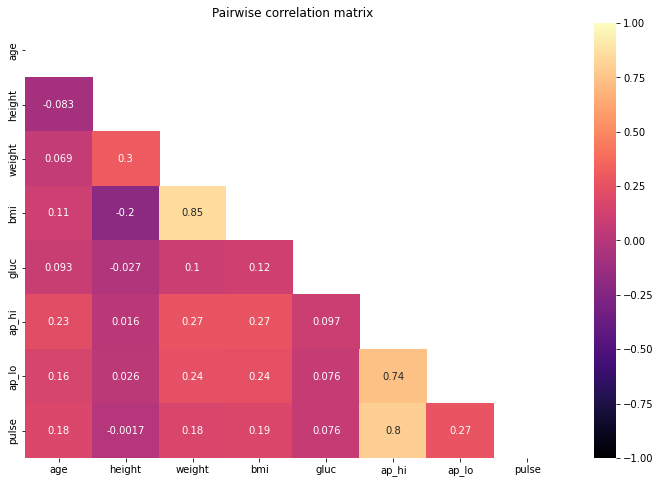

In [80]:
corr_matrix = Numdata.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 
plt.figure(figsize=(12,8))
sns.despine(top=True, right=True, bottom=True)
g1 = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1,annot=True, cmap="magma")
g1.set_title("Pairwise correlation matrix")

In [82]:
#spearman correlation
Numdata.corr(method='spearman')

,age,height,weight,bmi,gluc,ap_hi,ap_lo,pulse
age,1.000000,-0.082512,0.068891,0.114901,0.092794,0.225565,0.160172,0.184398
height,-0.082512,1.000000,0.297108,-0.197180,-0.026503,0.016160,0.025554,-0.001738
weight,0.068891,0.297108,1.000000,0.854692,0.100680,0.267739,0.244582,0.177919
bmi,0.114901,-0.197180,0.854692,1.000000,0.118854,0.269444,0.240684,0.185482
gluc,0.092794,-0.026503,0.100680,0.118854,1.000000,0.097215,0.076157,0.075743
ap_hi,0.225565,0.016160,0.267739,0.269444,0.097215,1.000000,0.740215,0.803525
ap_lo,0.160172,0.025554,0.244582,0.240684,0.076157,0.740215,1.000000,0.267569
pulse,0.184398,-0.001738,0.177919,0.185482,0.075743,0.803525,0.267569,1.000000


# **特徵工程**

### **特徵選擇**
sklearn中的模組：SelectKBest假設檢驗進行特徵選擇

某些特徵的存在可能是有害的。某些特徵可能彼此高度相關。

In [ ]:
#拆分應變量和自變量
x = cleaned_data.iloc[:, 0:-1]#自變數
y = cleaned_data.iloc[:, -1]
x,y

(       age  gender    height    weight      bmi  ap_hi  ap_lo  pulse  \
 0       50       2  5.123964  4.127134  1571.94    110     80     30   
 1       55       1  5.049856  4.442651  1742.14    140     90     50   
 2       51       1  5.105945  4.158883  1595.23    130     70     60   
 3       48       2  5.129899  4.406719  1674.55    150    100     50   
 4       47       1  5.049856  4.025352  1578.50    100     60     40   
 ...    ...     ...       ...       ...      ...    ...    ...    ...   
 67150   53       1  5.147494  4.248495  1603.41    130     90     40   
 67151   57       1  5.105945  4.382027  1680.83    150     80     70   
 67153   52       2  5.209486  4.653960  1714.88    180     90     90   
 67154   61       1  5.093750  4.276666  1648.28    135     80     55   
 67155   56       1  5.135798  4.276666  1621.40    120     80     40   
 
        cholesterol  gluc  smoke  alco  active  
 0                1     1      0     0       1  
 1                3     

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fit_feature = SelectKBest(score_func=f_classif)

In [ ]:
fit_feature.fit(x,y)

SelectKBest()

In [ ]:
score_col = pd.DataFrame(fit_feature.scores_,columns =['score value'])
score_col

,score value
0,3826.036808
1,0.009159
2,14.089851
3,2034.372441
4,2376.360621
5,14127.015873
6,8014.698494
7,7711.180617
8,3058.017032
9,417.615258


In [ ]:
name_col = pd.DataFrame(x.columns)
top_feature = pd.concat([name_col,score_col],axis=1)
top_feature

,0,score value
0,age,3826.036808
1,gender,0.009159
2,height,14.089851
3,weight,2034.372441
4,bmi,2376.360621
5,ap_hi,14127.015873
6,ap_lo,8014.698494
7,pulse,7711.180617
8,cholesterol,3058.017032
9,gluc,417.615258


In [ ]:
top_feature.nlargest(8,'score value')

,0,score value
5,ap_hi,14127.015873
6,ap_lo,8014.698494
7,pulse,7711.180617
0,age,3826.036808
8,cholesterol,3058.017032
4,bmi,2376.360621
3,weight,2034.372441
9,gluc,417.615258


In [ ]:
#特徵選擇
#因變量和自變量
X = cleaned_data.drop(['cardio', 'height', 'gender', 'smoke','active'], axis =1)
Y = cleaned_data['cardio']
#保留良好的數據，我們將刪除'gender'、'height'、'smoke'、'alco'、'active'

In [ ]:
X.head()
#得到資料集X

,age,weight,bmi,ap_hi,ap_lo,pulse,cholesterol,gluc,alco
0,50,4.127134,1571.94,110,80,30,1,1,0
1,55,4.442651,1742.14,140,90,50,3,1,0
2,51,4.158883,1595.23,130,70,60,3,1,0
3,48,4.406719,1674.55,150,100,50,1,1,0
4,47,4.025352,1578.50,100,60,40,1,1,0


In [ ]:
#剩下的資料欄位及型別
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63938 entries, 0 to 67155
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          63938 non-null  int64  
 1   weight       63938 non-null  float64
 2   bmi          63938 non-null  float64
 3   ap_hi        63938 non-null  int64  
 4   ap_lo        63938 non-null  int64  
 5   pulse        63938 non-null  int64  
 6   cholesterol  63938 non-null  int64  
 7   gluc         63938 non-null  int64  
 8   alco         63938 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 4.9 MB


### **特徵縮放**
建模前都應該要將各個特徵因子進行特徵縮放以標準化

In [ ]:
scaler = StandardScaler()
standard_X = scaler.fit_transform(X)

# **模型**

### **模型訓練**

In [ ]:
#訓練和測試數據(訓練資料集與測試資料集，訓練資料集用來訓練模型，當模型完成訓練過後，而後透過測試資料集來檢驗模型的好壞)
X_train, X_test, y_train, y_test = train_test_split(standard_X, Y, test_size=0.4, random_state=42, shuffle = True)
print("訓練集的大小:   ", X_train.shape[0])
print("測試集的大小:   ", X_test.shape[0])

訓練集的大小:    38362
測試集的大小:    25576


### K-**近鄰演算法**
 k 個最接近你的鄰居，可以快速將新數據分類到明確定義的類別中。



1.   決定 k 值
2.   求每個鄰居跟自己之間的距離
3.   找出跟自己最近的 k 個鄰居，查看哪一組鄰居數量最多，就加入哪一組

* fit: 放入X、y進行模型擬合。
* predict: 預測並回傳預測類別。
* score: 預測成功的比例。


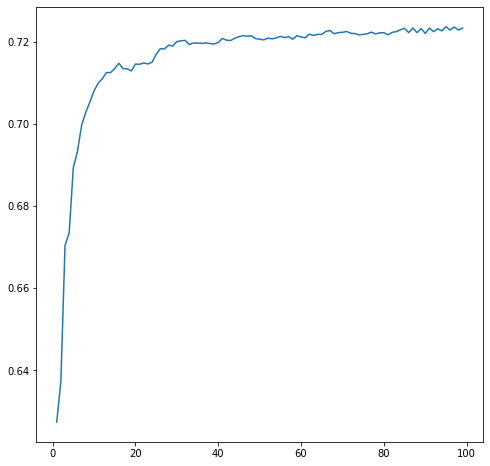

In [ ]:
#找尋適合的K值
from sklearn import metrics

accuracy = []
for k in range(1, 100):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, y_pred))
k_range = range(1,100)
plt.figure(figsize=(8, 8))
plt.plot(k_range, accuracy )
plt.show()
#透過把前述的所有步驟針對不同的K值都進行一次，經繪圖的方式看到合適K值的範圍。並回到步驟二的部分透過不斷的隨機切割樣本，測試K值得穩定度

In [ ]:
#模型建立(建立訓練模型)
knn = KNeighborsClassifier(n_neighbors=50, p=2, weights='uniform')
knn.fit(X_train, y_train) 
# n_neighbors: 要取幾個鄰居
# p: 選擇距離的計算方式(參數默認為2，也就是默認使用歐式距離公式進行距離度量。也可以設置為1，使用曼哈頓距離公式進行距離度量)
# weights: 投票方式為距離等權重或加權 (uniform是均等的權重，就說所有的鄰近點的權重都是相等的。 distance是不均等的權重，距離近的點比距離遠的點的影響大)
# algorithm:演算法的選擇 (計算效率的考慮)->默認參數為auto，可以理解為算法自己決定合適的搜索算法

KNeighborsClassifier(n_neighbors=50)

In [ ]:
#預測
from sklearn.metrics import accuracy_score
knn_predicted = knn.predict(X_test)
print(knn_predicted,'\n')
print(accuracy_score(y_test, knn_predicted))

[0 1 0 ... 0 0 1] 

0.7206365342508602


In [ ]:
# 預測成功的比例
knn_train = knn.score(X_train,y_train)
knn_test = knn.score(X_test,y_test)
print('訓練集: ',knn_train)
print('測試集: ',knn_test)

訓練集:  0.735884469005787
測試集:  0.7206365342508602


In [ ]:
scores = cross_val_score(knn, X_train, y_train, cv=10)
print('KNN Model gives an average accuracy of {0:.2f} % with minimun of {1:.2f} % and maximum of {2:.2f} % accuracy'.format(scores.mean() * 100, scores.min() * 100, scores.max() * 100))

KNN Model gives an average accuracy of 72.51 % with minimun of 70.88 % and maximum of 73.75 % accuracy


In [ ]:
from sklearn.metrics import classification_report
knn_predicted = knn.predict(X_test)
print(classification_report(y_test, knn_predicted))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73     12620
           1       0.75      0.67      0.71     12956

    accuracy                           0.72     25576
   macro avg       0.72      0.72      0.72     25576
weighted avg       0.72      0.72      0.72     25576



In [ ]:
from sklearn.metrics import confusion_matrix
print('True Positive Cases : {}'.format(confusion_matrix(y_test, knn_predicted)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, knn_predicted)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, knn_predicted)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, knn_predicted)[1][0]))

con_mat_knn = confusion_matrix(y_test,knn_predicted)
print("\n混亂矩陣:") 
print(con_mat_knn)

True Positive Cases : 8678
True Negative Cases : 9753
False Positive Cases : 2867
False Negative Cases : 4278

混亂矩陣:
[[9753 2867]
 [4278 8678]]


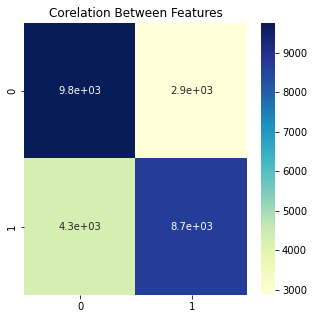

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.figure()
knn_cm = confusion_matrix(y_test, knn_predicted)
heatmap = sns.heatmap(knn_cm, annot=True, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()

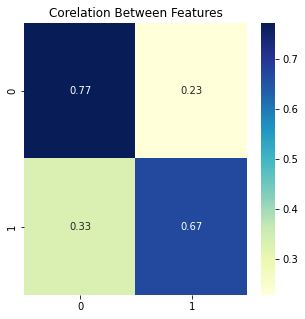

In [ ]:
#recall(召回率:成功預測多少比例)
knn_cm = knn_cm.astype('float') / knn_cm.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(knn_cm, annot=True, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()
#模型正确预测67%有心血管疾病的以及77%沒有心血管疾病的(TP、FP(假陽性)、FN(假陰性)、TN)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.metrics import specificity_score
def score(m, X_train, y_train, X_test, y_test, train=True):
  pred=m.predict(X_test)
  print('Test Result:\n')
  print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
  print(f"Precision Score: {precision_score(y_test, pred)*100:.2f}%")
  print(f"Specificity Score: {specificity_score(y_test, pred)*100:.2f}%")
  print(f"Recall Score: {recall_score(y_test, pred)*100:.2f}%")
  print(f"F1 score: {f1_score(y_test, pred)*100:.2f}%")
  print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")

In [ ]:
score(knn, X_train, y_train, X_test, y_test, train=True)

Test Result:

Accuracy Score: 72.06%
Precision Score: 75.17%
Specificity Score: 77.28%
Recall Score: 66.98%
F1 score: 70.84%
Confusion Matrix:
 [[9753 2867]
 [4278 8678]]


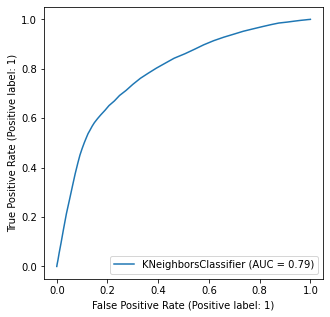

In [ ]:
#ROC 曲線是繪製真陽性率與假陽性率的概率曲線
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
plot_roc_curve(knn, X_test, y_test)
#速率越快，ROC曲線的行為越好(此模型的AUROC為0.78)
#AUC (Area Under Curve)曲線下面積 的值越大，代表分類器的正確率越高

### **隨機森林**
是進階版的決策樹，所謂的森林就是由很多棵決策樹所組成

*    n_estimators: 森林中樹木的數量，預設=100。
* max_features: 劃分時考慮的最大特徵數，預設auto。
* criterion: 分裂節點所用的標準，gini/entropy。預設為gini。
* max_depth: 樹的最大深度。
* splitter: 特徵劃分點選擇標準，best/random。預設為best。
*  random_state: 亂數種子，確保每次訓練結果都一樣splitter=random 才有用。
*  min_samples_split: 至少有多少資料才能再分
*  min_samples_leaf: 分完至少有多少資料才能分

In [ ]:
params = { 
    'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500],
    'max_depth' : [10,20,30,40,50],
    'criterion' : ['entropy','gini']
}

In [ ]:
rf = RandomForestClassifier(random_state=42, n_estimators=90, max_depth= 10, criterion = 'gini')
#其控制的是森林生成的模式(生成一片固定的森林)，而非讓一個森林之中只有一棵樹
#當模型的樹最大深度設定太大的話容易讓模型過擬合
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=90, random_state=42)

In [ ]:
# 預測成功的比例
rf_train = rf.score(X_train,y_train)
rf_test = rf.score(X_test,y_test)
print('訓練集: ',rf_train)
print('測試集: ',rf_test)

訓練集:  0.7553307961003076
測試集:  0.7279089771660933


In [ ]:
#準確率
scores = cross_val_score(rf, X_train, y_train, cv=10)
print('Random Forest Model gives an average accuracy of {0:.2f} % with minimun of {1:.2f} % and maximum of {2:.2f} % accuracy'.format(scores.mean() * 100, scores.min() * 100, scores.max() * 100))

Random Forest Model gives an average accuracy of 73.03 % with minimun of 71.56 % and maximum of 74.17 % accuracy


In [ ]:
from sklearn.metrics import classification_report
Y_hat = rf.predict(X_test)
print(classification_report(y_test, Y_hat))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     12620
           1       0.76      0.68      0.72     12956

    accuracy                           0.73     25576
   macro avg       0.73      0.73      0.73     25576
weighted avg       0.73      0.73      0.73     25576



In [ ]:
print('True Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, Y_hat)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, Y_hat)[1][0]))

con_mat_RF = confusion_matrix(y_test,Y_hat)
print("\n混亂矩陣:\n" , con_mat_RF) 


ｐrint("RF AUC:")
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, Y_hat)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

True Positive Cases : 8813
True Negative Cases : 9804
False Positive Cases : 2816
False Negative Cases : 4143

混亂矩陣:
 [[9804 2816]
 [4143 8813]]
RF AUC:
AUC = 0.7285


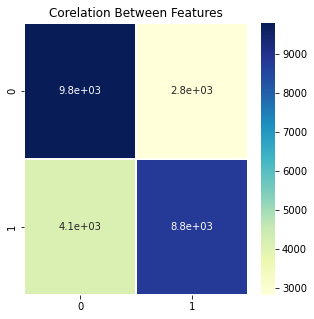

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.figure()
df_cm = confusion_matrix(y_test, Y_hat)
sns.heatmap(df_cm, annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()

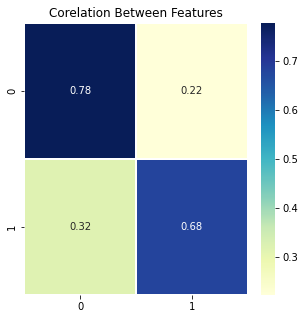

In [ ]:
#recall(召回率:成功預測多少比例)
df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(df_cm, annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()
#模型正确预测68%有心血管疾病的以及78%沒有心血管疾病的(TP、FP(假陽性)、FN(假陰性)、TN)

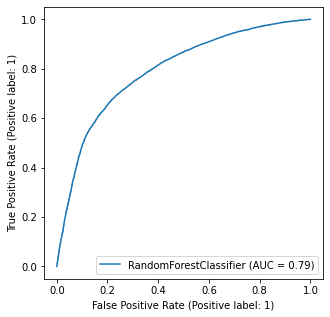

In [ ]:
#ROC 曲線是繪製真陽性率與假陽性率的概率曲線
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
plot_roc_curve(rf, X_test, y_test)
#速率越快，ROC曲線的行為越好(此模型的AUROC為0.79)

### **邏輯回歸**
分類演算法而不是迴歸演算法，用於判斷事件發生的機率。它可顯示不同特徵之間的關係，然後計算某個結果的發生機率。目標是要找出一條直線能夠將所有數據清楚地分開並做分類。(有心血管疾病及無)

**Parameters:**

* penalty: 正規化l1/l2，防止模型過度擬合。
* C: 數值越大對 weight 的控制力越弱，預設為1。
* n_init: 預設為10次隨機初始化，選擇效果最好的一種來作為模型。
* solver: 優化器的選擇。newton-cg,lbfgs,liblinear,sag,saga。預設為liblinear。
* multi_class: 選擇分類方式，ovr就是one-vs-rest(OvR)，而multinomial就是many-vs-many(MvM)。預設為 auto，故模型訓練中會取一個最好的結果。
* max_iter: 迭代次數，預設為100代。
* class_weight: 若遇資料不平衡問題可以設定balance，預設=None。
* random_state: 亂數種子僅在solver=sag/liblinear時有用。

solver：優化算法選擇參數
* liblinear：使用了開源的liblinear庫實現，內部使用了座標軸下降法來迭代優化損失函數。
* lbfgs：擬牛頓法的一種，利用損失函數二階導數矩陣即海森矩陣來迭代優化損失函數。
* newton-cg：也是牛頓法家族的一種，利用損失函數二階導數矩陣即海森矩陣來迭代優化損失函數。只用於L2
* sag：即隨機平均梯度下降，是梯度下降法的變種，和普通梯度下降法的區別是每次迭代僅僅用一部分的樣本來計算梯度，適合於樣本數據多的時候。只用於L2
* saga：線性收斂的隨機優化算法的的變重。只用於L2



In [ ]:
params_for_l1 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'saga']
}

params_for_l2 = { 
    'C' :  np.logspace(0, 4, 10),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

params_for_elasticnet = { 
    'C' :  np.logspace(0, 4, 10),
    'l1_ratio' : np.arange (0.1, 1.0, 0.1),
    'solver' : ['saga']
}

**penalty(l1): 模型的參數滿足拉普拉斯分佈**

In [ ]:
from sklearn.linear_model import LogisticRegression

# 建立Logistic模型
logisticModel = LogisticRegression(penalty = 'l1', solver = 'liblinear')#使用了座標軸下降法來迭代優化損失函數
# 使用訓練資料訓練模型
logisticModel.fit(X_train, y_train)
# 使用測試資料預測分類
y_pred_log = logisticModel.predict(X_test)

In [ ]:
Log_train = logisticModel.score(X_train,y_train)
Log_test = logisticModel.score(X_test,y_test)
print('訓練集: ',Log_train)
print('測試集: ',Log_test)

訓練集:  0.7263177102340859
測試集:  0.720284641851736


**penalty(l2): 默認爲l2，newton-cg、sag和lbfgs求解算法只支持L2規範,假設的模型參數滿足高斯分佈**

In [ ]:
from sklearn.linear_model import LogisticRegression

# 建立Logistic模型
logisticModel = LogisticRegression(penalty = 'l2', multi_class='auto', solver='saga',C = 1.0, random_state=1)
# 使用訓練資料訓練模型
logisticModel.fit(X_train, y_train)
# 使用測試資料預測分類
y_pred_log = logisticModel.predict(X_test)

In [ ]:
Log_train = logisticModel.score(X_train,y_train)
Log_test = logisticModel.score(X_test,y_test)
print('訓練集: ',Log_train)
print('測試集: ',Log_test)

訓練集:  0.7262916427714926
測試集:  0.7202455426962777


In [ ]:
scores = cross_val_score(logisticModel, X_train, y_train, cv=10)
print('Logistic Model with Elasticnet Penalty gives an average accuracy of {0:.2f} % with minimun of {1:.2f} % and maximum of {2:.2f} % accuracy'.format(scores.mean() * 100, scores.min() * 100, scores.max() * 100))

Logistic Model with Elasticnet Penalty gives an average accuracy of 72.60 % with minimun of 71.19 % and maximum of 74.09 % accuracy


In [ ]:
print(classification_report(y_test,y_pred_log))
con_mat_Log = confusion_matrix(y_test,y_pred_log)

              precision    recall  f1-score   support

           0       0.70      0.77      0.73     12620
           1       0.75      0.68      0.71     12956

    accuracy                           0.72     25576
   macro avg       0.72      0.72      0.72     25576
weighted avg       0.72      0.72      0.72     25576



In [ ]:
print('True Positive Cases : {}'.format(confusion_matrix(y_test, y_pred_log)[1][1]))
print('True Negative Cases : {}'.format(confusion_matrix(y_test, y_pred_log)[0][0]))
print('False Positive Cases : {}'.format(confusion_matrix(y_test, y_pred_log)[0][1]))
print('False Negative Cases : {}'.format(confusion_matrix(y_test, y_pred_log)[1][0]))

print("\n混亂矩陣:") 
print(con_mat_Log)
ｐrint("Log AUC:")
fpr_test, tpr_test, th_test = metrics.roc_curve(y_test, y_pred_log)
print('AUC = %.4f' %metrics.auc(fpr_test, tpr_test))

True Positive Cases : 8764
True Negative Cases : 9657
False Positive Cases : 2963
False Negative Cases : 4192

混亂矩陣:
[[9657 2963]
 [4192 8764]]
Log AUC:
AUC = 0.7208


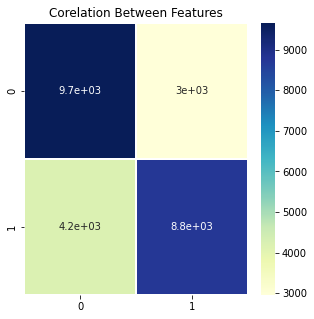

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.figure()
Log_cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(Log_cm, annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()

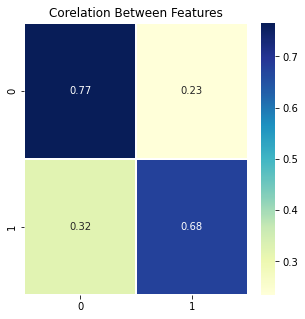

In [ ]:
#recall(召回率:成功預測多少比例)
Log_cm = Log_cm.astype('float') / Log_cm.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(Log_cm, annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Corelation Between Features')
plt.show()
#模型正确预测68%有心血管疾病的以及76%沒有心血管疾病的(TP、FP(假陽性)、FN(假陰性)、TN)

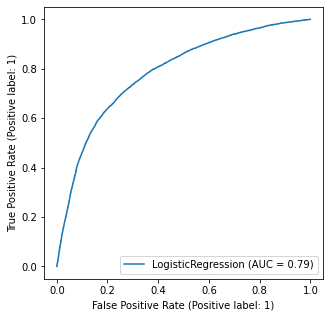

In [ ]:
#ROC 曲線是繪製真陽性率與假陽性率的概率曲線
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
plot_roc_curve(logisticModel, X_test, y_test)
#速率越快，ROC曲線的行為越好(此模型的AUROC為0.78)

# **模型評估**

**混亂矩陣**
混淆矩阵可以为我们提供更多关于我们的模型在每个结果中表现如何的信息。
* 真陽性：預測有 CVD 而實際上沒有 CVD 的病例數 
* 真陰性：預測沒有 CVD 且實際上沒有 CVD 的病例數
* 假陽性：預測有 CVD 且實際上沒有 CVD 的病例數 
* 假陰性：預測有 CVD 的病例數 沒有 CVD 而實際上有 CVD

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.metrics import specificity_score
def score(m, X_train, y_train, X_test, y_test, train=True):
  pred=m.predict(X_test)
  print('Test Result:\n')
  print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
  print(f"Precision Score: {precision_score(y_test, pred)*100:.2f}%")
  print(f"Specificity Score: {specificity_score(y_test, pred)*100:.2f}%")
  print(f"Recall Score: {recall_score(y_test, pred)*100:.2f}%")
  print(f"F1 score: {f1_score(y_test, pred)*100:.2f}%")
  print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")

In [ ]:
#Knn
score(knn, X_train, y_train, X_test, y_test, train=True)

Test Result:

Accuracy Score: 72.06%
Precision Score: 75.17%
Specificity Score: 77.28%
Recall Score: 66.98%
F1 score: 70.84%
Confusion Matrix:
 [[9753 2867]
 [4278 8678]]


In [ ]:
#RF
score(rf, X_train, y_train, X_test, y_test, train=True)

Test Result:

Accuracy Score: 72.79%
Precision Score: 75.78%
Specificity Score: 77.69%
Recall Score: 68.02%
F1 score: 71.69%
Confusion Matrix:
 [[9804 2816]
 [4143 8813]]


In [ ]:
#Log
score(logisticModel, X_train, y_train, X_test, y_test, train=True)

Test Result:

Accuracy Score: 72.02%
Precision Score: 74.73%
Specificity Score: 76.52%
Recall Score: 67.64%
F1 score: 71.01%
Confusion Matrix:
 [[9657 2963]
 [4192 8764]]


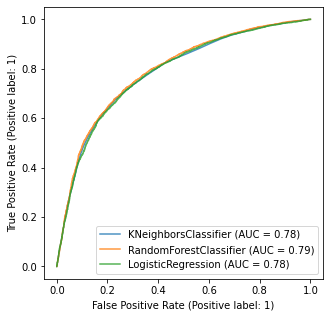

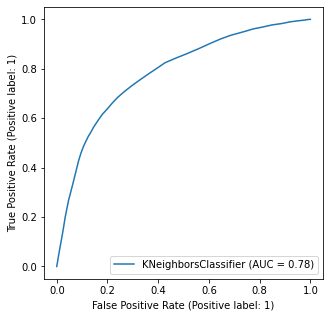

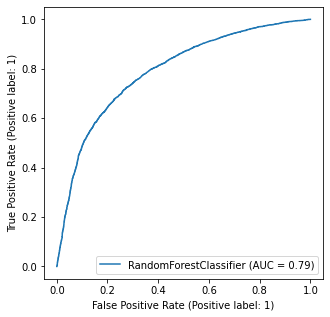

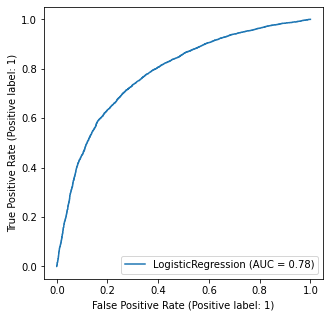

In [ ]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
for model in models:
    RocCurveDisplay.from_estimator(model[1].fit( X_train, y_train), X_test, y_test).plot(ax=ax, alpha=0.8)
#plt.show()

In [ ]:
data = [(' K-nearest Neighbor Classifier', knn_train,knn_test),
 ('Random Forest Classifier', rf_train,rf_test,),
 ('Logistic Regression', Log_train,Log_test )]

Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy'])

Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy
Model Name,,
K-nearest Neighbor Classifier,0.736266,0.721536
Random Forest Classifier,0.751202,0.724116
Logistic Regression,0.725064,0.718095


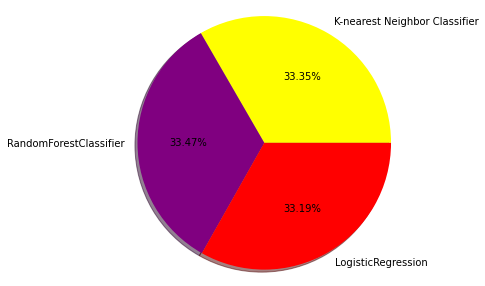

In [ ]:
import matplotlib.pyplot as plt
Algorithm=["K-nearest Neighbor Classifier", "RandomForestClassifier", "LogisticRegression"]
algo=[knn_test,rf_test,Log_test]
plt.pie(algo,explode=[0,0,0],labels=Algorithm,shadow =True, autopct="%.2f%%",colors=['yellow','purple','red'])
plt.axis("equal")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
# Spot Check Algorithms
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=45, p=1, weights='uniform')))
models.append(('RF', RandomForestClassifier(random_state=42, n_estimators=90, max_depth= 10, criterion = 'gini')))
models.append(('Log', LogisticRegression(multi_class='auto', solver='newton-cg',random_state=0)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    #使用 cv ，並用validation data 計算 validation error 判斷哪種模型比較好
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

KNN: 0.724438 (0.006791)
RF: 0.729990 (0.006539)
Log: 0.724966 (0.006014)


In [ ]:
## 這邊假設覺得 SVM classifier的模型表現最好，想以 SVM classifier 作為最終選擇的模型
model = SVC(gamma='auto')
model.fit(x_train, y_train)
predictions = model.predict(x_test)
# Evaluate predictions
# # 0:'setosa', 1:'versicolor', 2:'virginica'
print(accuracy_score(y_test, predictions)) #準確率
print(confusion_matrix(y_test, predictions)) # 混淆矩陣confusion matrix
print(classification_report(y_test, predictions))